<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/5_Dinamic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# Feature engineering and scaling

In [4]:
data = mf.feature_engineering(data)
data = mf.feature_scaling(data)
data = pd.get_dummies(data)

# Dinamic model

In [5]:
init_splits = 4 # numero di split su cui il modello iniziale (t=0) si allena 
incoming_splits = 2 # nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
tot_splits = 10 # split totali in cui sarà diviso il dataset

In [6]:
def get_split_id(data, init_splits, incoming_splits, tot_splits): # serve per splittare il dataset in tot_splits
  '''
  in
  data: dataset che si vuole splittare
  init_splits: numero di split su cui il modello iniziale (t=0) si allena 
  incoming_splits: nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
  tot_splits: split totali in cui sarà diviso il dataset
  out
  id: dizionario che contiene (split : id righe selezionate)
  id_fraud: come id, solo che sono selezionate solo le transazioni fraudolente 
  '''
  id = {} # dizionario con (split : id_righe)
  id_fraud = {} # dizionario con (split: id righe transazioni fraudolente)
  for i in range(tot_splits):
    id[i] = data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits))].index.tolist()
    id_fraud[i] = data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits)) & (data['isFraud'] == 1)].index.tolist()
    
  return id, id_fraud

In [7]:
class model:
  name = 'XGBoost'

  def __init__(self, t): # costruttore
    '''
    in
    t: istante temporale
    '''
    self.t = t
    self.f1 = 0
    self.precision = 0
    self.recall = 0
    self.roc = 0
    self.proba = []
    self.prediction = []
    self.train_id = [] # lista con le righe su cui il modello si è allenato
    self.val_id = [] # lista con le righe su cui il modello viene validato
    return

  def __str__(self): # print dell'oggetto
    return f"{self.name}, at time {self.t}, with f1 score of {self.f1}"

  def init_xgb(self, estimators = 2000, depth = 6): # inizializza xgb 2000, 6
    import xgboost 
    from xgboost import XGBClassifier
    self.xgb = XGBClassifier(n_estimators = estimators, max_depth = depth, 
                      objective='binary:logistic', learning_rate = 0.5, 
                      tree_method='gpu_hist')
    return f'{self.name} at time {self.t}, has been initialized.'
  
  def train_xgb(self, X_train, y_train): # traina il modello
    # self.xgb.fit(X_train.to_numpy(), y_train.to_numpy())
    self.xgb.fit(X_train.to_numpy(), y_train)
    return f'{self.name} is now trained!'

  def get_set(self, data, id_list): # restituisce il subset dati gli id delle righe
    # id_list: è l'elemento id[t] 
    subset = data.iloc[id_list,:]
    return subset

  def proba_predictions(self, X_val): # restituisce le probabilità
    if not self.xgb:
      return f'{self.name} is not declared. You need to use init_xgb'
    self.proba = self.xgb.predict_proba(X_val, validate_features = False)
    return self.proba

  def aggregate(self, soglia = 0.05): # resituisce la classe
    # if not self.proba:
    #   return f'self.proba is empty. Before aggregate, you need to use proba_predictions'
    self.prediction = []
    for proba in self.proba[:,1]:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

  def performance(self, y_val, soglia = 0.05): # printa le performance del modello 
    from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
    
    print('\n')
    print('Confusion matrix of model', self.name,'of time', self.t)
    mf.plot_cm(y_val, self.prediction, 'Blues', p = soglia, dynamic = True)
    
    self.score = f1_score(y_val, self.prediction).round(2)
    self.roc = roc_auc_score(y_val, self.prediction).round(2)
    self.precision = precision_score(y_val, self.prediction,  average='binary').round(2)
    self.recall = recall_score(y_val, self.prediction, average='binary').round(2)

    print('\n')
    print('Model f1 score: ', self.score)
    print('Model roc auc score: ', self.roc)
    print('Model recall: ', self.recall)
    print('Model precision: ', self.precision)
    print('\n')
    return 

In [8]:
class nn(model):
  name = 'Neural network'

  def init_nn(self, n_features):
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
    self.nn = Sequential()
    self.nn.add(Input(shape=(n_features,))) 
    self.nn.add(Dense(1024, activation='relu')) 
    self.nn.add(Dropout(0.2)) 
    self.nn.add(Dense(512, activation='relu')) 
    self.nn.add(Dropout(0.2)) 
    self.nn.add(Dense(256, activation='relu')) 
    self.nn.add(Dropout(0.2))
    self.nn.add(Dense(128, activation='relu')) 
    self.nn.add(Dropout(0.2))
    self.nn.add(Dense(24, activation='relu')) 
    self.nn.add(Dropout(0.2))
    self.nn.add(Dense(4, activation='relu')) 
    self.nn.add(Dropout(0.2))
    self.nn.add(Dense(1, activation='sigmoid')) 

    self.nn.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return f'{self.name} initialized'

  def train_nn(self, X_train, y_train):
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    history = self.nn.fit(X_train.to_numpy(), y_train, 
                          epochs=20, batch_size=2000, 
                          # epochs=20, batch_size=2000, 
                          validation_data=(X_val.to_numpy(), y_val), verbose=1, shuffle = True)
    return f'{self.name} trained.'

  #override
  def proba_predictions(self, X_val): # restituisce le probabilità
    if not self.nn:
      return f'{self.name} is not declared. You need to use init_nn'
    self.proba = self.nn.predict(X_val.to_numpy())#, validate_features = False)
    return self.proba

  #override
  def aggregate(self, soglia = 0.5): # resituisce la classe
    self.prediction = []
    for proba in self.proba:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

In [9]:
class ensemble(model): # child class di model
  name = 'Ensemble'
  # come model_dict passare il dizionario in cui si salvano gli ensemble

  #override 
  def proba_predictions(self, model_dict, X_val): # restituisce le probabilità predette 
    prob = []
    for t in model_dict:
      if model_dict[t].name == 'XGBoost':
        prob.append(model_dict[t].proba_predictions(X_val)[:,1])
      if model_dict[t].name == 'Neural network':
        prob.append(model_dict[t].proba_predictions(X_val))
    self.proba = np.mean(prob, axis = 0)
    return f'Proba acquired.'
  
  #override
  def aggregate(self, soglia = 0.05): # restituisce la classe predetta 
    for proba in self.proba:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

In [10]:
def get_t_id(data, id, id_fraud, t, init_splits, incoming_splits): # restituisce la lista degli id corrispondente all'istante temporale t 
  '''
  data: dataset da cui selezionare le transazioni
  id: lista con gli id delle righe
  t: istante temporale
  init_splits: split totali in cui sarà diviso il dataset
  incoming_splits: nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
  out
  id_list: lista con gli id delle righe selezionate a seconda dell'istante temporale specificato  
  '''
  id_list = [] # lista che conterrà le righe da usare al tempo t
  id_list_fraud = [] # lista che conterrà le righe con transazioni fraud da usare al tempo t

  if t == 0: 
    start = 0
    end = init_splits
  else:
    start = incoming_splits * (t - 1) + init_splits
    end = start + incoming_splits

  if t == 1:
    start_fraud = 0
    end_fraud = init_splits
  else:
    start_fraud = 0
    end_fraud = incoming_splits * (t - 1) + init_splits + incoming_splits 

    

  for n in range(start,end):
    id_list += id[n]
  
  if t > 0:
    for n in range(start_fraud, end_fraud):
      id_list_fraud += id_fraud[n]

  return id_list, id_list_fraud

In [11]:
def train_model(sel_model, last_model, data, id_t, id_fraud_t, keep_fraud, keep_safe): # funzione per sistemare il dataset e trainare il modello
  '''
  sel_model: modello da trainare
  data: dataset
  id_t: id delle righe su cui trainare il modello
  '''
  import random 



  # Train test split
  subset = sel_model.get_set(data, id_t) # seleziono il subset su cui il modello si allenerà
  X_train, X_val, y_train, y_val = mf.split(subset, test_size = 0.2) # train test split

  # unione transazioni fraudolente degli step precedenti
  if keep_fraud:
    X_train_fraud = sel_model.get_set(data, id_fraud_t)
    X_train_fraud.drop(columns = ['isFraud'], inplace = True)
  if keep_safe:
    sample_size = int(np.ceil(len(last_model.train_id) * 0.1))
    id_safe_t = random.sample(last_model.train_id, sample_size)
    X_train_safe = last_model.get_set(data, id_safe_t)
    X_train_safe.drop(columns = ['isFraud'], inplace = True)

  if keep_safe and keep_fraud:
    X_train = pd.concat([X_train, X_train_fraud, X_train_safe])
    y_train_safe = np.zeros(X_train_safe.shape[0])
    y_train_fraud = np.ones(X_train_fraud.shape[0])
    y_train = np.concatenate((y_train, y_train_fraud, y_train_safe), axis=None)

  if keep_safe and not keep_fraud:
    X_train = pd.concat([X_train, X_train_fraud])
    y_train_fraud = np.ones(X_train_fraud.shape[0])
    y_train = np.concatenate((y_train, y_train_fraud), axis=None)

  # salvataggio degli id nel modello
  sel_model.train_id = X_train.index.tolist() # salvo gli id del training set 
  sel_model.val_id = X_val.index.tolist() # salvo gli id del test set

  # Training del modello
  if sel_model.name == 'XGBoost':
    sel_model.init_xgb() # inizializzo xgb
    sel_model.train_xgb(X_train, y_train) # train di xgb 
  
  if sel_model.name == 'Neural network':
    n_features = X_train.shape[1]
    sel_model.init_nn(n_features)
    sel_model.train_nn(X_train, y_train)


  return f'Training ended. \n'

In [12]:
def test_model(sel_model, model_dict, t, data, soglia): # test del modello
  '''
  in
  sel_model: modello da trainare
  model_dict: dizionario contenente i vari modelli
  t: istante temporale
  data: dataset
  soglia: soglia sulla probabilità 
  '''
  id_list = []
  for i in model_dict:
    id_list += model_dict[i].val_id
  # id_list = last_model.val_id # seleziono le righe su cui va validato l'ultimo modello
  subset = sel_model.get_set(data, id_list) # seleziono il set su cui valido i dati
  y_val = subset['isFraud']
  X_val = subset.drop(columns=['isFraud'], axis = 1)

  sel_model.proba_predictions(X_val) # predict_proba
  sel_model.aggregate(soglia = soglia) # predict

  sel_model.performance(y_val, soglia = soglia) # valuta le performance del modello
  return 

In [13]:
def test_ensemble(ens, model_dict, t, data, id_t, soglia): # testa le performance dell'ensemble
  '''
  ens: ensemble da testare 
  model_dict: dizionario con i modelli
  t: istante temporale
  data: dataset
  id_t: righe da usare all'istante t-esimo
  '''
  id_list = []
  for i in model_dict:
    id_list += model_dict[i].val_id
  subset = model_dict[t].get_set(data, id_list) # seleziono il set su cui valido i dati
  # subset = model_dict[t].get_set(data, id_t) # seleziono il set su cui valido i dati
  y_val = subset['isFraud']
  X_val = subset.drop(columns=['isFraud'], axis = 1)
  ens.proba_predictions(model_dict, X_val) # predict_proba dell'ensemble
  ens.aggregate(soglia = soglia) # predict dell'ensemble
  ens.performance(y_val, soglia = soglia) # valuto le performance
  return f'Ensemble testing ended. \n'

In [14]:
def get_best_model(xgb, nn):
  if xgb.score > nn.score:
    return xgb
  else:
    return nn

In [15]:
def dinamic_model(data, id, id_fraud, init_splits, incoming_splits, tot_splits, keep_fraud, keep_safe):
  tmax = np.ceil((tot_splits - init_splits) / incoming_splits)
  model_dict = {}
  xgb_dict = {}
  nn_dict = {}
  ensemble_dict = {}
  soglia_xgb = 0.7 # 0.05
  soglia_nn = 0.7
  soglia_ens = 0.7

  for t in range(int(tmax + 1)):
    print('Time ', t)
    id_t, id_fraud_t = get_t_id(data, id, id_fraud, t, init_splits, incoming_splits) # ottengo gli id delle righe da usare al tempo t-esimo
    # model_dict[t] = model(t) # inizializzo il modello t-esimo 
    xgb_dict[t] = model(t)
    nn_dict[t] = nn(t)
    if t == 0:
      # train_model(model_dict[t], None, data, id_t, id_fraud_t, keep_fraud = False, keep_safe = False) # train e test del modello t-esimo
      train_model(xgb_dict[t], None, data, id_t, id_fraud_t, keep_fraud = False, keep_safe = False) # train e test del modello t-esimo
      train_model(nn_dict[t], None, data, id_t, id_fraud_t, keep_fraud = False, keep_safe = False) # train e test del modello t-esimo
      
      test_model(xgb_dict[t], xgb_dict, t, data, soglia_xgb)
      test_model(nn_dict[t], nn_dict, t, data, soglia_nn)
      model_dict[t] = get_best_model(xgb_dict[t], nn_dict[t])
      print(model_dict[t].name, 'has been chosen.')

    if t > 0:
      # train_model(model_dict[t], model_dict[t-1], data, id_t, id_fraud_t, keep_fraud, keep_safe) # train e test del modello t-esimo
      train_model(xgb_dict[t], model_dict[t-1], data, id_t, id_fraud_t, keep_fraud, keep_safe) # train e test del modello t-esimo
      train_model(nn_dict[t], model_dict[t-1], data, id_t, id_fraud_t, keep_fraud, keep_safe) # train e test del modello t-esimo
      
      test_model(xgb_dict[t], xgb_dict, t, data, soglia_xgb)
      test_model(nn_dict[t], nn_dict, t, data, soglia_nn)
      model_dict[t] = get_best_model(xgb_dict[t], nn_dict[t])
      print(model_dict[t].name, 'has been chosen.')

      ensemble_dict[t] = ensemble(t) # inizializzo l'ensemble t-esimo
      test_ensemble(ensemble_dict[t], model_dict, t, data, id_t, soglia_ens) # testo l'ensemble
    # for i in model_dict:
    #   test_model(model_dict[i], model_dict, t, data, soglia)

  return model_dict, ensemble_dict

Time  0
Epoch 1/20
85/85 [==============================] - 3s 22ms/step - loss: 0.3298 - accuracy: 0.8727 - val_loss: 0.1310 - val_accuracy: 0.9668
Epoch 2/20
85/85 [==============================] - 1s 12ms/step - loss: 0.2344 - accuracy: 0.9575 - val_loss: 0.1188 - val_accuracy: 0.9668
Epoch 3/20
85/85 [==============================] - 1s 13ms/step - loss: 0.2231 - accuracy: 0.9625 - val_loss: 0.1180 - val_accuracy: 0.9668
Epoch 4/20
85/85 [==============================] - 1s 12ms/step - loss: 0.2103 - accuracy: 0.9661 - val_loss: 0.1099 - val_accuracy: 0.9670
Epoch 5/20
85/85 [==============================] - 1s 13ms/step - loss: 0.2027 - accuracy: 0.9684 - val_loss: 0.1060 - val_accuracy: 0.9713
Epoch 6/20
85/85 [==============================] - 1s 12ms/step - loss: 0.1929 - accuracy: 0.9704 - val_loss: 0.1054 - val_accuracy: 0.9719
Epoch 7/20
85/85 [==============================] - 1s 12ms/step - loss: 0.1872 - accuracy: 0.9708 - val_loss: 0.0998 - val_accuracy: 0.9727
Epoch

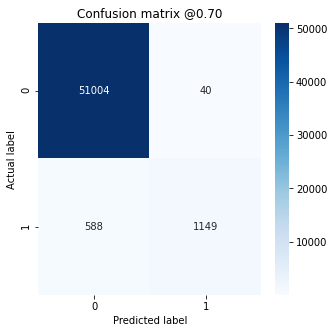



Model f1 score:  0.79
Model roc auc score:  0.83
Model recall:  0.66
Model precision:  0.97




Confusion matrix of model Neural network of time 0


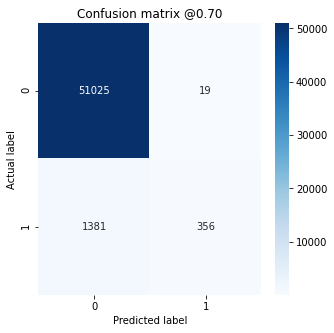



Model f1 score:  0.34
Model roc auc score:  0.6
Model recall:  0.2
Model precision:  0.95


XGBoost has been chosen.
Time  1


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
50/50 [==============================] - 2s 25ms/step - loss: 0.4146 - accuracy: 0.8292 - val_loss: 0.2448 - val_accuracy: 0.9027
Epoch 2/20
50/50 [==============================] - 1s 13ms/step - loss: 0.2873 - accuracy: 0.8995 - val_loss: 0.2293 - val_accuracy: 0.9027
Epoch 3/20
50/50 [==============================] - 1s 13ms/step - loss: 0.2692 - accuracy: 0.8998 - val_loss: 0.2237 - val_accuracy: 0.9158
Epoch 4/20
50/50 [==============================] - 1s 13ms/step - loss: 0.2594 - accuracy: 0.9102 - val_loss: 0.2131 - val_accuracy: 0.9202
Epoch 5/20
50/50 [==============================] - 1s 13ms/step - loss: 0.2500 - accuracy: 0.9149 - val_loss: 0.2047 - val_accuracy: 0.9244
Epoch 6/20
50/50 [==============================] - 1s 13ms/step - loss: 0.2381 - accuracy: 0.9201 - val_loss: 0.2002 - val_accuracy: 0.9267
Epoch 7/20
50/50 [==============================] - 1s 13ms/step - loss: 0.2374 - accuracy: 0.9240 - val_loss: 0.1999 - val_accuracy: 0.9283
Epoch 8/20
50

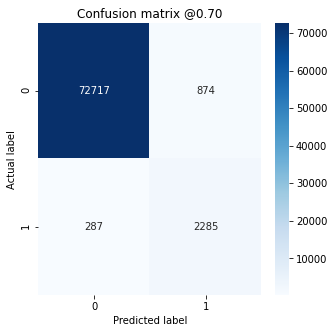



Model f1 score:  0.8
Model roc auc score:  0.94
Model recall:  0.89
Model precision:  0.72




Confusion matrix of model Neural network of time 1


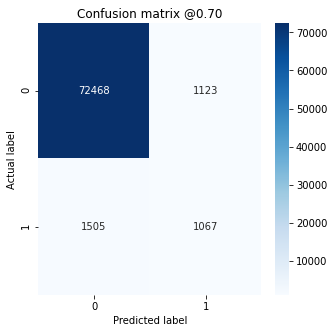



Model f1 score:  0.45
Model roc auc score:  0.7
Model recall:  0.41
Model precision:  0.49


XGBoost has been chosen.


Confusion matrix of model Ensemble of time 1


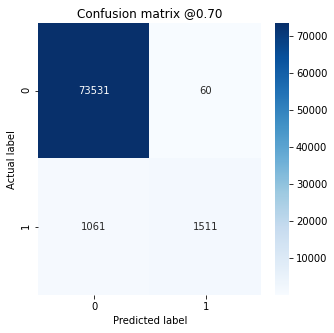



Model f1 score:  0.73
Model roc auc score:  0.79
Model recall:  0.59
Model precision:  0.96


Time  2


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
46/46 [==============================] - 2s 22ms/step - loss: 0.5551 - accuracy: 0.7523 - val_loss: 0.3738 - val_accuracy: 0.8212
Epoch 2/20
46/46 [==============================] - 1s 16ms/step - loss: 0.4220 - accuracy: 0.8362 - val_loss: 0.3153 - val_accuracy: 0.8763
Epoch 3/20
46/46 [==============================] - 1s 13ms/step - loss: 0.3908 - accuracy: 0.8651 - val_loss: 0.2939 - val_accuracy: 0.8835
Epoch 4/20
46/46 [==============================] - 1s 13ms/step - loss: 0.3696 - accuracy: 0.8769 - val_loss: 0.2769 - val_accuracy: 0.8862
Epoch 5/20
46/46 [==============================] - 1s 13ms/step - loss: 0.3596 - accuracy: 0.8854 - val_loss: 0.2828 - val_accuracy: 0.8935
Epoch 6/20
46/46 [==============================] - 1s 13ms/step - loss: 0.3492 - accuracy: 0.8908 - val_loss: 0.2598 - val_accuracy: 0.8966
Epoch 7/20
46/46 [==============================] - 1s 13ms/step - loss: 0.3293 - accuracy: 0.8998 - val_loss: 0.2521 - val_accuracy: 0.9048
Epoch 8/20
46

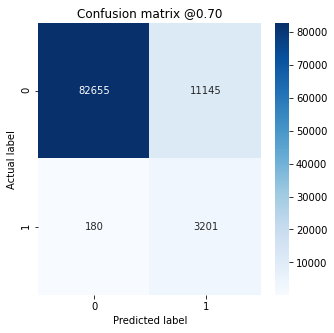



Model f1 score:  0.36
Model roc auc score:  0.91
Model recall:  0.95
Model precision:  0.22




Confusion matrix of model Neural network of time 2


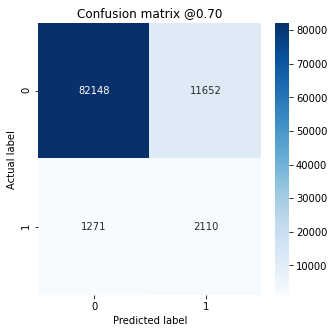



Model f1 score:  0.25
Model roc auc score:  0.75
Model recall:  0.62
Model precision:  0.15


XGBoost has been chosen.


Confusion matrix of model Ensemble of time 2


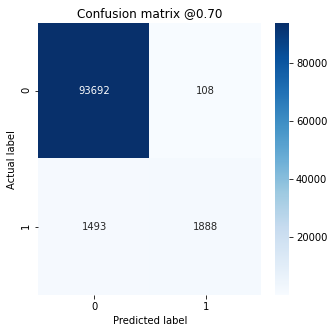



Model f1 score:  0.7
Model roc auc score:  0.78
Model recall:  0.56
Model precision:  0.95


Time  3


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
47/47 [==============================] - 2s 25ms/step - loss: 0.5051 - accuracy: 0.7961 - val_loss: 0.3603 - val_accuracy: 0.7978
Epoch 2/20
47/47 [==============================] - 1s 13ms/step - loss: 0.3893 - accuracy: 0.7947 - val_loss: 0.3247 - val_accuracy: 0.7978
Epoch 3/20
47/47 [==============================] - 1s 13ms/step - loss: 0.3468 - accuracy: 0.8008 - val_loss: 0.3019 - val_accuracy: 0.8947
Epoch 4/20
47/47 [==============================] - 1s 13ms/step - loss: 0.3278 - accuracy: 0.8873 - val_loss: 0.2951 - val_accuracy: 0.8992
Epoch 5/20
47/47 [==============================] - 1s 13ms/step - loss: 0.3124 - accuracy: 0.8962 - val_loss: 0.2961 - val_accuracy: 0.8980
Epoch 6/20
47/47 [==============================] - 1s 13ms/step - loss: 0.3114 - accuracy: 0.8985 - val_loss: 0.2872 - val_accuracy: 0.9038
Epoch 7/20
47/47 [==============================] - 1s 13ms/step - loss: 0.3039 - accuracy: 0.9030 - val_loss: 0.2829 - val_accuracy: 0.9022
Epoch 8/20
47

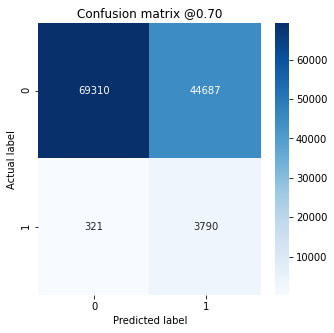



Model f1 score:  0.14
Model roc auc score:  0.76
Model recall:  0.92
Model precision:  0.08




Confusion matrix of model Neural network of time 3


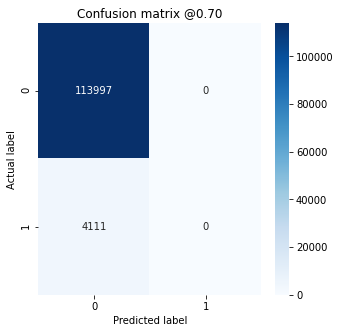

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Model f1 score:  0.0
Model roc auc score:  0.5
Model recall:  0.0
Model precision:  0.0


XGBoost has been chosen.


Confusion matrix of model Ensemble of time 3


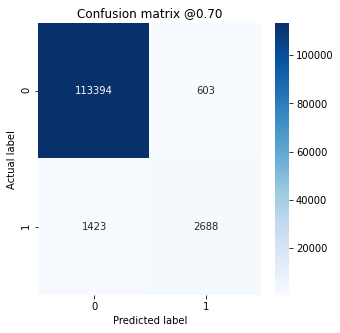



Model f1 score:  0.73
Model roc auc score:  0.82
Model recall:  0.65
Model precision:  0.82




In [16]:
id, id_fraud = get_split_id(data, init_splits, incoming_splits, tot_splits) # splitta le righe in base agli split dichiarati
model_dict, ensemble_dict = dinamic_model(data, id, id_fraud, init_splits, incoming_splits, tot_splits, keep_fraud = True, keep_safe = True)